<a href="https://colab.research.google.com/github/FedericoSabbadini/DeepLearning/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning
Author: Nicola Arici (nicola.arici@unibs.it)

Transfer learning is a key technique in deep learning that allows us to leverage the knowledge learned by a model trained on one task and apply it to another, often related, task. Instead of training a model from scratch—which can be computationally expensive and data-hungry—we start with a pretrained model and adapt it to our specific dataset. This approach is especially useful when working with limited data or resources.

In this notebook, we will apply transfer learning using PyTorch. We’ll start with a ResNet50 model pretrained on the large-scale ImageNet dataset and adapt it to classify images from the Flower102 dataset.

**Resources**

- [Torchvision Models](https://docs.pytorch.org/vision/stable/models.html)



First, we’ll explore the available pretrained models and learn how to load and use them in our workflow.

In [9]:
from torchvision.models import resnet50, ResNet50_Weights
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Device", device)

weights = ResNet50_Weights.IMAGENET1K_V2
model = resnet50(weights=weights).to(device)

preprocess = weights.transforms()
class_names = weights.meta["categories"]

model

Device cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Then, we’ll test the adapted model using a few new sample images to evaluate its performance.

In [10]:
from io import BytesIO
from PIL import Image
import requests
import os

TEST_IMAGE = {
    'banana': 'https://cdn.gvmnet.it/admingvm/media/immagininews/fegatostomacoeintestino/banane_benefici.jpeg',
    'space shuttle': 'https://media-cldnry.s-nbcnews.com/image/upload/t_fit-1500w,f_auto,q_auto:best/msnbc/Components/Photos/060519/060519_shuttle_vlg6p.jpg',
    'French horn': 'https://www.normans.co.uk/cdn/shop/articles/french_horn.jpg?v=1663242562',
    'beacon': 'https://aa-images.co.uk/wp-content/uploads/2021/11/157-New-Brighton-Lighthouse-on-the-beach-scaled-1.jpg',
    'tiger': 'https://files.worldwildlife.org/wwfcmsprod/images/Tiger_resting_Bandhavgarh_National_Park_India/hero_small/6aofsvaglm_Medium_WW226365.jpg'
}


batch = None
labels = []
for label, img in TEST_IMAGE.items():
    response = requests.get(img)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    pImg = preprocess(img)

    if batch is None:
        batch = pImg.unsqueeze(0)   # (1, 3, 224, 224)
    else:
        batch = torch.cat((batch, pImg.unsqueeze(0)), dim=0)  # stack along batch dimension

    labels.append(label)

batch = batch.to(device)
model.eval
with torch.no_grad():
    preds = model(batch)

correct = 0
for true_label, p in zip(labels, preds):
    pred_label = p.argmax(dim=-1).item()

    if true_label == class_names[pred_label]:
        correct += 1

print(f"Accuracy: {correct}/{len(TEST_IMAGE)} ")

Accuracy: 4/5 


The Flower102 dataset is a well-known benchmark for image classification tasks. It contains 8,189 images of flowers spanning 102 categories, including a wide variety of species commonly found in the United Kingdom. Each class has between 40 and 258 images, providing a moderate challenge due to its fine-grained distinctions and varying lighting conditions, scales, and poses.

This dataset is often used to evaluate transfer learning and fine-tuning techniques, as it is small enough for rapid experimentation yet diverse enough to test a model’s ability to generalize across visually similar classes.

**Resources**:

- [Torchvision FLower102](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.Flowers102.html#torchvision.datasets.Flowers102)


In [15]:
from torchvision.datasets import Flowers102
import matplotlib.pyplot as plt


train_set = Flowers102(root='data', split='train', download=True, transform=preprocess)
val_set = Flowers102(root='data', split='val', download=True, transform=preprocess)
test_set = Flowers102(root='data', split='test', download=True, transform=preprocess)

Some stats...

In [16]:
print(f"# Trainset: {len(train_set)}")
print(f"# Valset: {len(val_set)}")
print(f"# Testsett: {len(test_set)}")

print("------------------------------------")

print(f"Data shape: {train_set[0][0].shape}")
print(f"# classes: {len(train_set.classes)}")

# Trainset: 1020
# Valset: 1020
# Testsett: 6149
------------------------------------
Data shape: torch.Size([3, 224, 224])
# classes: 102


In [18]:
# funzione necessaria per normalizzazione
def denorm(img):
    img = img.permute(1, 2, 0)  # CxHxW → HxWxC
    img = img * RESNET_STD + RESNET_MEAN       # undo normalization
    img = torch.clamp(img, 0, 1) # keep in [0,1]
    return img.numpy()

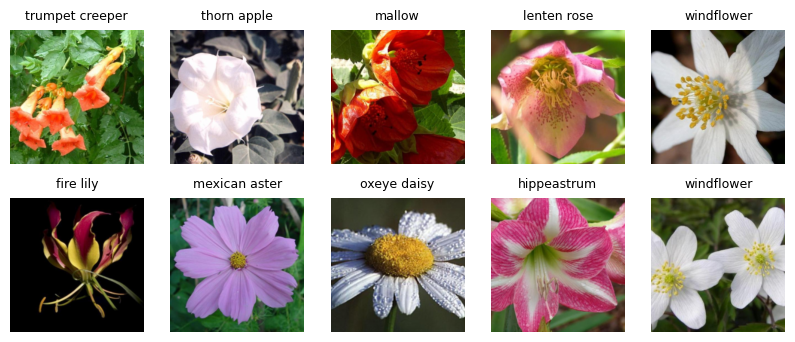

In [19]:
import random

RESNET_MEAN = torch.tensor([0.485, 0.456, 0.406])
RESNET_STD = torch.tensor([0.229, 0.224, 0.225])

random.seed(34566754)
images, labels = zip(*[train_set[i] for i in random.choices(range(len(train_set)), k=10)])

# Create 5x5 grid
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i, ax in enumerate(axes.flat):
    img = images[i]

    ax.imshow(denorm(img))
    ax.set_title(train_set.classes[labels[i]], fontsize=9, pad=8)
    ax.axis('off')

plt.show()


And let's test ResNet50 over FLower102

In [20]:
from tabulate import tabulate

headers = ["True", "Predicted"]
data = []

for image, label in zip(images, labels):
    model.eval()
    with torch.no_grad():
        preds = model(image.unsqueeze(0).to(device))
        pred_label = preds.argmax(dim=-1).item()

        data.append([ train_set.classes[label], class_names[pred_label]])

print(tabulate(data, headers=headers))

True             Predicted
---------------  -----------------
trumpet creeper  pot
thorn apple      vase
mallow           sulphur butterfly
lenten rose      bee
windflower       daisy
fire lily        artichoke
mexican aster    daisy
oxeye daisy      daisy
hippeastrum      bee
windflower       daisy


--> come si vede, prestazioni non ottime. Sbaglia troppo. SERVE IL TRANSFER LEARNING

# Transfer Learning


Il transfer learning si basa sul freeze dei pesi

> Cosa si intende per "freeze" dei pesi?

Questa tecnica è tipicamente usata in un contesto di fine-tuning, cioè quando prendi un modello pre-addestrato (ad esempio, un modello come ResNet, VGG, ecc.) e lo adattato a un compito specifico. Per farlo, spesso congeli i pesi della rete di base (backbone) e addestri solo una parte finale, ad esempio gli strati superiori o una "testa" personalizzata (un layer di classificazione).

Scenario tipico:

Fase 1: Usa una rete pre-addestrata come "backbone" per l'estrazione delle feature (congelando i pesi).

Fase 2: Aggiungi nuovi strati finali per il compito specifico (ad esempio, un classificatore).

Fase 3: Addestra solo i nuovi strati, mentre i pesi del backbone rimangono congelati.

Questo approccio è vantaggioso quando non hai molte risorse computazionali o dati, poiché ti permette di sfruttare una rete già addestrata su un grande set di dati (come ImageNet) senza dover ripartire da zero.



Let's create a custom model

In [33]:
import torch.nn as nn
from tqdm import tqdm

class FlowerModel(nn.Module):

    def __init__(self, device, num_classes=102):
        super(FlowerModel, self).__init__()

        weights = ResNet50_Weights.IMAGENET1K_V2

        self.backbone = resnet50(weights=weights)

        # modalità con freeze. Inizialmente parto senza pesi e dopo un attimo li utilizzo.
        # NON DEVO ADDESTRARE LA RETE ALL'INIZIO. UTILE SE HO UN MODELLO PREALLENATO
        for param in self.backbone.parameters():
            param.requires_grad = False
            # l'alternativa è mettere i pesi iniziali a None e togliere queste due righe sopra

        self.backbone.fc = nn.Linear(2048, 102)

        self.device = device
        self.best_val_loss = float('inf')

        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
            # Label smoothing distributes a small amount of the probability mass from
            # the true label to all other labels. For example, if you have 3 classes (0,
            # 1, and 2) and the true label is 0, with a label smoothing of 0.1, the
            # target probability distribution becomes [0.9, 0.05, 0.05] instead of [1,
            # 0, 0]. If the true label were 1, the smoothed target would be [0.05, 0.9,
            # 0.05], and if it were 2, it would be [0.05, 0.05, 0.9].

    def forward (self, img):
        return self.backbone(img)

    def unfreeze (self, img):
        for param in self.backbone.parameters():
            param.requires_grad = True


    def train_classifier(self, train_dataloader, val_dataloader, epochs, optimizer, early_stop_ep=5):

        train_loss = []
        train_accs = []

        val_loss = []
        val_accs = []

        best_model_wts = self.state_dict()
        ep_without_impr = 0

        for ep in range(epochs):
            self.train()
            running_loss = 0.0
            acc = 0
            total = 0

            for it, (images, labels) in enumerate(tqdm(train_dataloader, desc="Train")):

                images = images.to(self.device)
                labels = labels.to(self.device)

                # Forward pass
                logits = self.forward(images)
                loss = self.criterion(logits, labels)

                running_loss += loss.item()

                # Backpropagation
                loss.backward()
                optimizer.step()

                optimizer.zero_grad()

                # Accuracy
                predictions = torch.max(logits, 1).indices

                acc += (predictions.detach().cpu() == labels.detach().cpu()).sum().item()
                total += len(labels)

            epoch_loss = running_loss/len(train_dataloader)
            train_loss.append(epoch_loss)

            epoch_acc = acc*100/total
            train_accs.append(epoch_acc)

            ### VALIDATION
            ep_val_loss, ep_val_acc = self.eval_classifier(val_dataloader)

            val_loss.append(ep_val_loss)
            val_accs.append(ep_val_acc)

            if ep_val_loss < self.best_val_loss:
                self.best_val_loss = ep_val_loss
                ep_without_impr=0
                best_model_wts = self.state_dict()
            else:
                ep_without_impr += 1

            print(f"\nEpoch {ep+1}: Val Loss {round(ep_val_loss, 3)} - Val Accuracy {round(ep_val_acc, 2)}%\n")

            if ep_without_impr == early_stop_ep:
                print("Early stopping")
                break

        self.load_state_dict(best_model_wts)
        return train_loss, train_accs, val_loss, val_accs


    def eval_classifier(self, dataloader):
        self.eval()

        val_loss = 0
        val_accs = 0
        total = 0

        for it, (images, labels) in enumerate(tqdm(dataloader, desc="Val")):

            with torch.no_grad():
                images = images.to(self.device)
                labels = labels.to(self.device)

                # Forward pass
                logits = self.forward(images)

                loss = self.criterion(logits, labels)
                val_loss += loss.item()

                predictions = torch.max(logits, 1).indices
                val_accs += (predictions.detach().cpu() == labels.detach().cpu()).sum().item()
                total += len(labels)

        return val_loss/len(dataloader), val_accs/total*100


    def predict(self, dataloader):
        self.eval()

        predictions = []
        for it, (images, labels) in enumerate(tqdm(dataloader)):

            with torch.no_grad():
                images = images.to(self.device)

                logits = self.forward(images)
                predictions.extend(logits.detach().cpu().numpy().tolist())

        return predictions

In [37]:
from torch.utils.data import DataLoader

BS = 32

trainloader = DataLoader(train_set, batch_size=BS, shuffle=True, num_workers=2)
valloader = DataLoader(val_set, batch_size=BS, num_workers=2)
testloader = DataLoader(test_set, batch_size=BS, num_workers=2)


flowerModel = FlowerModel(device).to(device)
optimizer = torch.optim.Adam(flowerModel.backbone.parameters(), lr=1e-2)
epochs = 8

train_loss, train_accs, val_loss, val_accs = flowerModel.train_classifier(trainloader, valloader, epochs, optimizer)


Val: 100%|██████████| 32/32 [00:06<00:00,  4.74it/s]



Epoch 1: Val Loss 1.899 - Val Accuracy 73.33%



Val: 100%|██████████| 32/32 [00:06<00:00,  4.63it/s]



Epoch 2: Val Loss 1.621 - Val Accuracy 81.67%



Val: 100%|██████████| 32/32 [00:07<00:00,  4.46it/s]



Epoch 3: Val Loss 1.605 - Val Accuracy 83.82%



Val: 100%|██████████| 32/32 [00:07<00:00,  4.51it/s]



Epoch 4: Val Loss 1.693 - Val Accuracy 82.75%



Val: 100%|██████████| 32/32 [00:07<00:00,  4.33it/s]



Epoch 5: Val Loss 1.688 - Val Accuracy 82.65%



Val: 100%|██████████| 32/32 [00:07<00:00,  4.55it/s]



Epoch 6: Val Loss 1.681 - Val Accuracy 85.59%



Val: 100%|██████████| 32/32 [00:07<00:00,  4.54it/s]



Epoch 7: Val Loss 1.703 - Val Accuracy 84.71%



Val: 100%|██████████| 32/32 [00:08<00:00,  3.87it/s]


Epoch 8: Val Loss 1.749 - Val Accuracy 84.12%

Early stopping


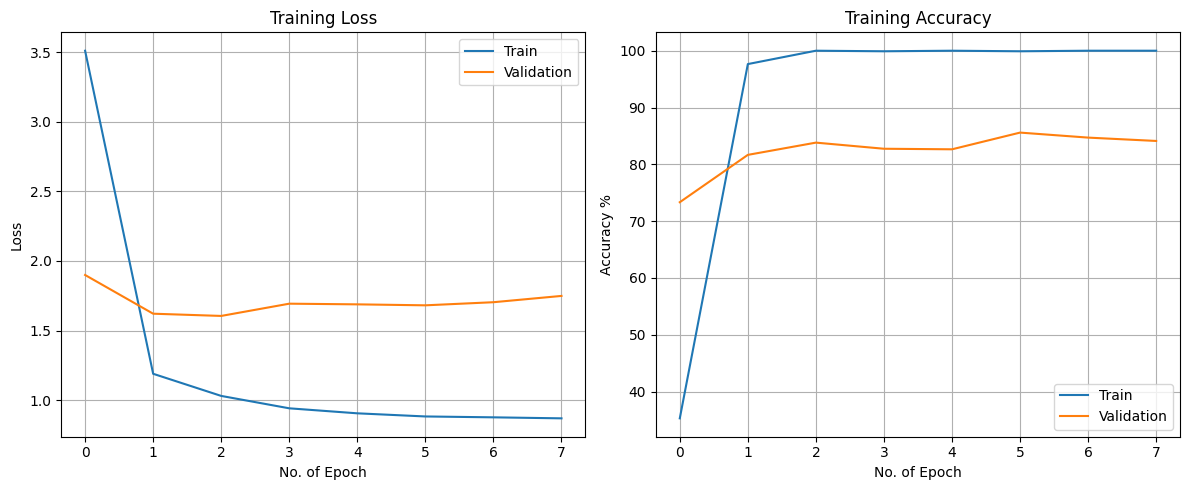

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(range(len(train_loss)), train_loss, label="Train")
axs[0].plot(range(len(val_loss)), val_loss, label="Validation")
axs[0].set_xlabel("No. of Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training Loss")
axs[0].grid()
axs[0].legend()

axs[1].plot(range(len(train_accs)), train_accs, label="Train")
axs[1].plot(range(len(val_accs)), val_accs, label="Validation")
axs[1].set_xlabel("No. of Epoch")
axs[1].set_ylabel("Accuracy %")
axs[1].set_title("Training Accuracy")
axs[1].grid()
axs[1].legend()

plt.tight_layout()
plt.show()

In [39]:
_, test_acc = flowerModel.eval_classifier(testloader)
print(f"\nAccuracy on Testset: {round(test_acc, 2)}%")

Val: 100%|██████████| 193/193 [00:43<00:00,  4.48it/s]


Accuracy on Testset: 81.59%


Val: 100%|██████████| 32/32 [00:06<00:00,  4.64it/s]



Epoch 1: Val Loss 1.699 - Val Accuracy 78.63%



Val: 100%|██████████| 32/32 [00:07<00:00,  4.49it/s]



Epoch 2: Val Loss 1.551 - Val Accuracy 84.41%



Val: 100%|██████████| 32/32 [00:06<00:00,  5.23it/s]



Epoch 3: Val Loss 1.432 - Val Accuracy 85.49%



Val: 100%|██████████| 32/32 [00:07<00:00,  4.55it/s]



Epoch 4: Val Loss 1.496 - Val Accuracy 84.9%



Val: 100%|██████████| 32/32 [00:06<00:00,  5.21it/s]



Epoch 5: Val Loss 1.405 - Val Accuracy 88.92%



Val: 100%|██████████| 32/32 [00:06<00:00,  4.72it/s]



Epoch 6: Val Loss 1.362 - Val Accuracy 91.27%



Val: 100%|██████████| 32/32 [00:06<00:00,  4.90it/s]



Epoch 7: Val Loss 1.356 - Val Accuracy 93.14%



Val: 100%|██████████| 32/32 [00:06<00:00,  5.25it/s]



Epoch 8: Val Loss 1.369 - Val Accuracy 92.16%



Val: 100%|██████████| 32/32 [00:07<00:00,  4.50it/s]



Epoch 9: Val Loss 1.358 - Val Accuracy 93.24%



Val: 100%|██████████| 32/32 [00:06<00:00,  5.16it/s]



Epoch 10: Val Loss 1.37 - Val Accuracy 91.96%



Val: 100%|██████████| 32/32 [00:07<00:00,  4.53it/s]



Epoch 11: Val Loss 1.381 - Val Accuracy 92.65%



Val: 100%|██████████| 32/32 [00:06<00:00,  4.67it/s]



Epoch 12: Val Loss 1.394 - Val Accuracy 94.9%

Early stopping


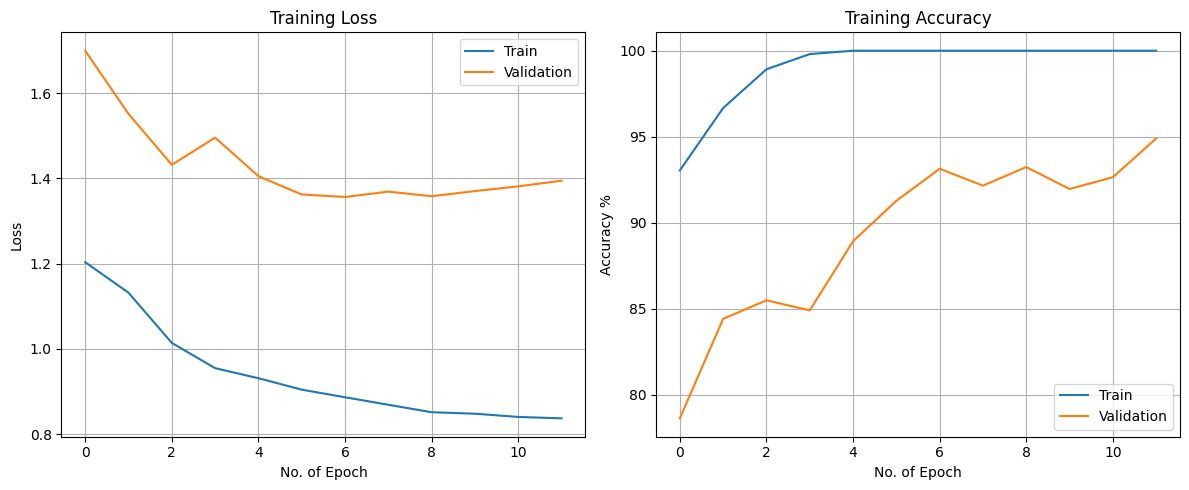

In [42]:
optimizer = torch.optim.AdamW(flowerModel.parameters(), lr=1e-3, weight_decay=1e-5)
# serve un 2' optimizier. è buona norma usare un lr diverso e altri parametri.
# è ANCHE IMPORTANTE PER SFREEZARE IL MODELLO
# AdamW si usa su reti molto profonde per cui si intende migliorare di più i livelli finali che quelli iniziali

epochs = 25
flowerModel.unfreeze(device)
train_loss, train_accs, val_loss, val_accs = flowerModel.train_classifier(trainloader, valloader, epochs, optimizer)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(range(len(train_loss)), train_loss, label="Train")
axs[0].plot(range(len(val_loss)), val_loss, label="Validation")
axs[0].set_xlabel("No. of Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training Loss")
axs[0].grid()
axs[0].legend()

axs[1].plot(range(len(train_accs)), train_accs, label="Train")
axs[1].plot(range(len(val_accs)), val_accs, label="Validation")
axs[1].set_xlabel("No. of Epoch")
axs[1].set_ylabel("Accuracy %")
axs[1].set_title("Training Accuracy")
axs[1].grid()
axs[1].legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

--> Epoch 9: Val Loss 1.358 - Val Accuracy 93.24%

--> Epoch 12: poi si ferma per Early Stopping prima delle 25

In [43]:
_, test_acc = flowerModel.eval_classifier(testloader)
print(f"\nAccuracy on Testset: {round(test_acc, 2)}%")

Val: 100%|██████████| 193/193 [00:40<00:00,  4.82it/s]


Accuracy on Testset: 91.62%


L'uso del "freeze" dei pesi in modelli pre-addestrati è ancora molto comune in determinati contesti, ma negli ultimi anni ci sono stati degli sviluppi che hanno cambiato un po' la prospettiva su quando e come utilizzarlo. Vediamo le ragioni per cui potresti non vederlo tanto frequentemente in alcune implementazioni moderne.


Un motivo per cui il "freeze" non è più così popolare come una tecnica universale è che oggi si preferisce spesso fine-tuning completo.
**Invece di congelare tutti i pesi di una rete pre-addestrata, molti ricercatori e praticanti optano per un fine-tuning su tutta la rete. Questo approccio, pur essendo più costoso computazionalmente, permette di adattare meglio il modello ai dati specifici del tuo compito, specialmente quando hai abbastanza dati o risorse computazionali.**

RICORDA! Il fine-tuning è una tecnica nell’ambito del machine learning (e in particolare del deep learning) che consiste nel prendere un modello già pre-addestrato su un grande dataset generico e poi adattarlo (cioè ri-addestrarlo) su un dataset più piccolo e specifico per un compito particolare.

In particolare, i modelli pre-addestrati moderni, come i transformer (es. BERT, GPT), beneficiano molto di un fine-tuning completo, che permette al modello di affinare la sua rappresentazione anche nelle prime fasi della rete, che potrebbero essere più generali (per esempio, in una rete neurale convoluzionale, le prime convoluzioni apprendono caratteristiche generiche come bordi e texture).